In this note, we numerically study the expansion of a surface code.
We first study the expansion without post-selection.

In [2]:
import numpy as np
import stim
import matplotlib.pyplot as plt
import pymatching
import sinter
from typing import List

In [ ]:
class SurfaceCode:
    def __init__(self, m: int, n: int, error_rate: float = 0.001):
        self.m = m # Number of columns
        self.n = n # Number of rows
        self.error_rate = error_rate
        self.data_dict, self.data_list = self.generate_data_dict_and_list()
        self.check_list = self.generate_check_list()
        self.total_qubit_number = 0
        # print(self.check_list)

    def generate_data_dict_and_list(self):
        """
        data_dict: (for finding index of a data qubit from position)
            key: position, 
            value: index,
        data_list: list of indices (for loop over data qubits)
        """
        data_dict = {}
        data_list = []
        idx = 0
        for i in range(self.m):
            for j in range(self.n):
                data_dict[(2 * i, 2 * j)] = idx
                data_list.append(idx)
                idx += 1
        return data_dict, data_list

    def generate_check_list(self):
        """
        list of dicts: {
            'type': 'X' or 'Z',
            'pos': position,
            'idx': index,
            'data_qubits'; indices of data qubits to check
        }
        """
        check_list = []
        idx = self.m * self.n
        # X checks
        for i in range(0, self.m + 1, 2):
            for j in range(self.n - 1):
                pos = [2 * i - 1 + 2 * (j % 2), 2 * j + 1]
                if pos[0] <= 2 * self.m - 1:
                    check_list.append({
                        'type': 'X',
                        'pos': pos,
                        'idx': idx,
                        'data_qubits': [
                            self.data_dict.get((pos[0] - 1, pos[1] - 1)),
                            self.data_dict.get((pos[0] - 1, pos[1] + 1)),
                            self.data_dict.get((pos[0] + 1, pos[1] - 1)),
                            self.data_dict.get((pos[0] + 1, pos[1] + 1)),
                        ]
                    })
                    idx += 1
        # Z checks
        for i in range(self.m - 1):
            for j in range(0, self.n + 1, 2):
                pos = [2 * i + 1, 2 * j + 1 - 2 * (i % 2)]
                if pos[1] <= 2 * self.n - 1:
                    check_list.append({
                        'type': 'Z',
                        'pos': pos,
                        "idx": idx,
                        'data_qubits': [
                            self.data_dict.get((pos[0] - 1, pos[1] - 1)),
                            self.data_dict.get((pos[0] + 1, pos[1] - 1)),
                            self.data_dict.get((pos[0] - 1, pos[1] + 1)),
                            self.data_dict.get((pos[0] + 1, pos[1] + 1)),
                        ]
                    })
                    idx += 1
        return check_list

    def generate_circuit(self, rounds: int = 10):
        self.total_qubit_number = len(self.data_list) + len(self.check_list)
        circuit = self.initialize_circuit_position()
        self.initialize_circuit(circuit)
        for t in range(rounds):
            self.syndrome_measurement(circuit, t)
        self.Z_measurement(circuit, rounds)
        return circuit

    def initialize_circuit_position(self):
        circuit = stim.Circuit()
        for pos in self.data_dict:
            circuit.append("QUBIT_COORDS", self.data_dict[pos], pos)
        for check in self.check_list:
            circuit.append("QUBIT_COORDS", check['idx'], check['pos'])
        return circuit

    def initialize_circuit(self, circuit: stim.Circuit):
        circuit = self.initialize_circuit_position()
        # Initialize data qubits
        for i in self.data_list:
            circuit.append("R", i)
        # Initialize ancilla qubits
        for i in range(len(self.check_list)):
            if self.check_list[i]['type'] == 'X':
                circuit.append("R", self.check_list[i]['idx'])
            else:
                circuit.append("R", self.check_list[i]['idx'])

    def syndrome_measurement(self, circuit: stim.Circuit, round: int):
        # initialize X-check ancillae
        for check in self.check_list:
            if check['type'] == 'X':
                circuit.append('H', check['idx'])
        for check in self.check_list:
            if check['type'] == 'X':
                circuit.append("DEPOLARIZE1", check['idx'], self.error_rate)
        circuit.append('TICK')

        # CNOT layers
        for i in range(4):
            for check in self.check_list:
                if check['type'] == 'X' and check['data_qubits'][i] != None:
                    circuit.append('CNOT', [check['idx'], check['data_qubits'][i]])
                if check['type'] == 'Z' and check['data_qubits'][i] != None:
                    circuit.append('CNOT', [check['data_qubits'][i], check['idx']])
            for check in self.check_list:
                if check['type'] == 'X' and check['data_qubits'][i] != None:
                    circuit.append("DEPOLARIZE2", [check['idx'], check['data_qubits'][i]], self.error_rate)
                    # circuit.append("CORRELATED_ERROR", [check['idx'], check['data_qubits'][i]], self.error_rate)
                if check['type'] == 'Z' and check['data_qubits'][i] != None:
                    circuit.append("DEPOLARIZE2", [check['data_qubits'][i], check['idx']], self.error_rate)
                    # circuit.append("CORRELATED_ERROR", [check['data_qubits'][i], check['idx']], self.error_rate)
            circuit.append('TICK')

        # Hadamard layer for X-check ancillae
        for check in self.check_list:
            if check['type'] == 'X':
                circuit.append('H', check['idx'])
        for check in self.check_list:
            if check['type'] == 'X':
                circuit.append("DEPOLARIZE1", [check['idx']], self.error_rate)
        circuit.append('TICK')

        # syndrome measurement
        for check in self.check_list:
            circuit.append('X_ERROR', [check['idx']], self.error_rate)
        for check in self.check_list:
            circuit.append('MR', [check['idx']])
        circuit.append("DEPOLARIZE1", list(range(2 * self.m * self.n - 1)), self.error_rate)
        circuit.append('TICK')

        # if detector is required, add detector operations
        if round > 0:
            for check in self.check_list:
                rec_idx = check['idx'] - 2 * self.m * self.n + 1 # shift (mn, 2mn-1) to (-mn+1, 0)
                circuit.append('DETECTOR', [stim.target_rec(rec_idx), stim.target_rec(rec_idx - self.m * self.n + 1)], [check['pos'][0], check['pos'][1], round])
        else:
            for check in self.check_list:
                if check['type'] == 'Z':
                    rec_idx = check['idx'] - 2 * self.m * self.n + 1
                    circuit.append('DETECTOR', [stim.target_rec(rec_idx)], [check['pos'][0], check['pos'][1], round])

    def Z_measurement(self, circuit: stim.Circuit, round: int):
        # Measure all data qubits
        circuit.append('X_ERROR', self.data_list, self.error_rate)
        circuit.append('MR', self.data_list)

        # Extract Z-syndrome and make a detector
        for check in self.check_list:
            if check['type'] == 'Z':
                qubit_rec_shift = - self.m * self.n # shift (0, mn) to (-mn, 0)
                check_rec_shift = - 3 * self.m * self.n + 1 # shift (mn, 2mn-1) to (-2mn + 1, -mn)
                detector_list = [stim.target_rec(check['idx'] + check_rec_shift)] + [stim.target_rec(check['data_qubits'][i] + qubit_rec_shift) for i in range(4) if check['data_qubits'][i] != None]
                circuit.append('DETECTOR', detector_list, [check['pos'][0], check['pos'][1], round])

        # Extract logical Z
        qubit_rec_shift = - self.m * self.n # shift (0, mn) to (-mn, 0)
        logical_Z = [stim.target_rec(i + qubit_rec_shift) for i in range(self.n)]
        circuit.append('OBSERVABLE_INCLUDE', logical_Z, 0)

    def grow_code(self, circuit: stim.Circuit, rounds: int, m_new, n_new):
        pass

    def reset_indices_for_growth(self, m_new, n_new):
        self.m = m_new
        self.n = n_new
        new_data_dict, new_data_list = self.generate_data_dict_and_list()
        new_check_list = self.generate_check_list()
        
        # build data index map
        data_map = {}
        for data_qubit_position in new_data_dict:
            if data_qubit_position in self.data_dict:
                new_data_dict[data_qubit_position] = self.data_dict[data_qubit_position]
            else:
                if new_data_dict[data_qubit_position] not in self.indices_used:
        self.data_dict = {}
        self.check_list = []
        self.initialize_qubits(m_new, n_new)

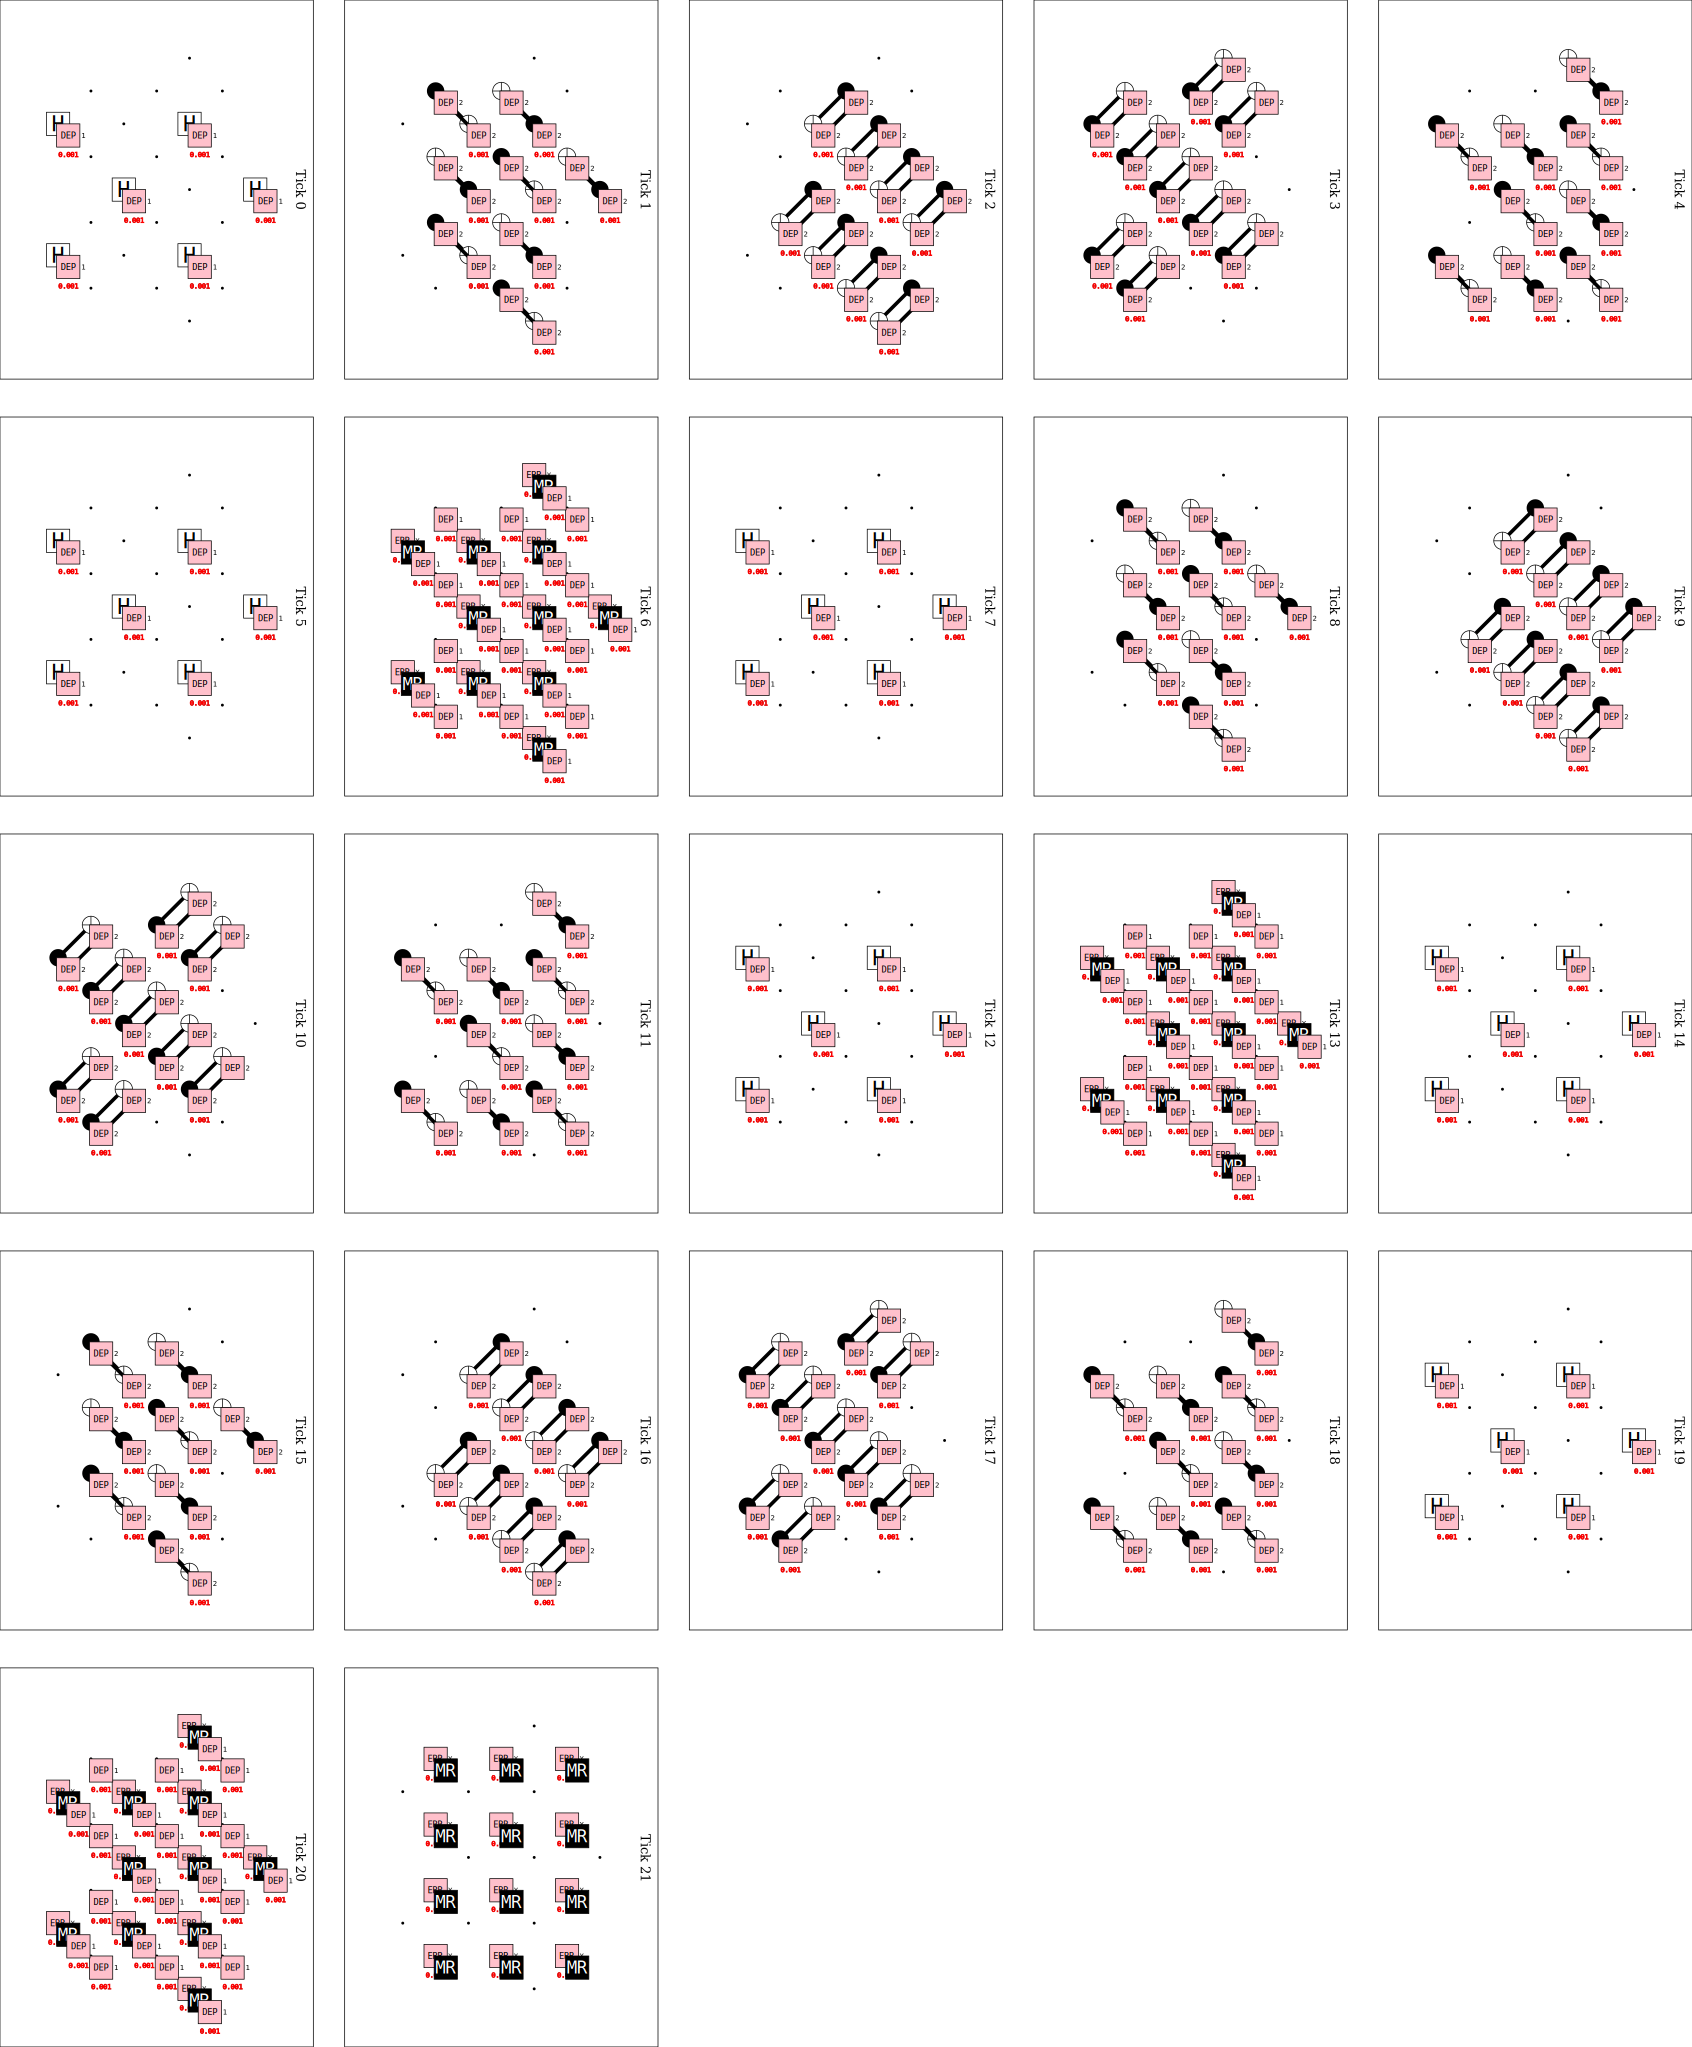

In [30]:
surface_code = SurfaceCode(m=3, n=4, error_rate=0.001)
circuit = surface_code.generate_circuit(rounds=3)
circuit.diagram('timeslice-svg')

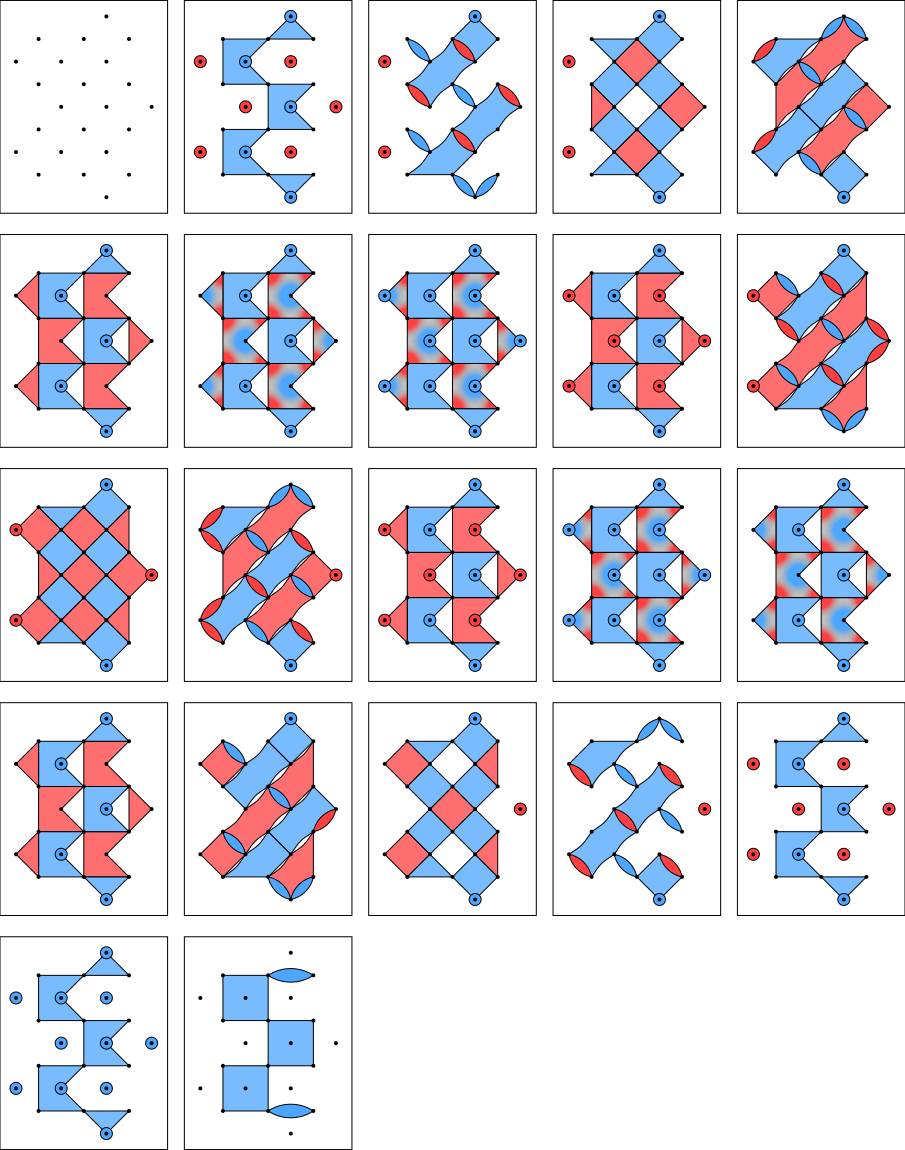

In [19]:
circuit.diagram('detslice-svg')

In [31]:
def circuit_to_simulate(d, noise, rounds):
    surface_code = SurfaceCode(d, d, noise)
    circuit = surface_code.generate_circuit(rounds)
    return circuit

tasks = [
    sinter.Task(
        circuit = circuit_to_simulate(d, noise, d),
        json_metadata={'d': d, 'noise': noise}
    )
    for d in [3, 5, 7]
    for noise in np.linspace(0.001, 0.01, 10)
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=16,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=5000,
)

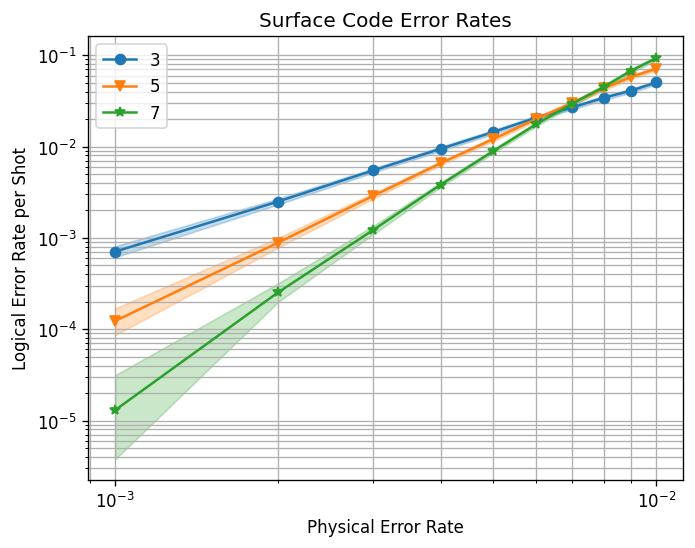

In [32]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['noise'],
    group_func=lambda stats: stats.json_metadata['d'],
)
# ax.set_ylim(1e-6, 5e-1)
# ax.set_xlim(5e-4, 1e-2)
ax.loglog()
ax.set_title("Surface Code Error Rates")
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger